In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#Data loading and pre-processing
train_X = pd.read_csv('train.csv')
test_X = pd.read_csv('test.csv' )
train_X.drop(train_X.columns[train_X.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_X.drop(test_X.columns[test_X.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

train_result = pd.read_csv('train_result.csv')
train_y_class = train_result['Class']

In [3]:
#Removing negative values from the features with zeros. 
#Later this step was not performed as there is any change in the LR training. So used the original features as such.
#train_X = train_X.mask(train_X < 0.0, 0.0)
#test_X = test_X.mask(train_X < 0.0, 0.0)
#train_X

In [4]:
#Converting Pandas dataframe into Numpy Array
X_train = train_X.to_numpy() # (m, c) dimension m = examples in train dataset
X_test = test_X.to_numpy()   # (m, c) dimension m = examples in test dataset
train_y = train_y_class.to_numpy() #(m,)

print(train_y.shape)
print(X_train.shape)
print(X_test.shape)

(50000,)
(50000, 1568)
(10000, 1568)


In [5]:
def one_hot(y, c):
    '''
    Function for one hot ecoding
    Arguments:
    y--> label/ground truth.
    c--> Number of classes.
    
    Return:
        one-hot encoded y values
    
    '''
    
    # A zero matrix of size (m, c)
    y_hot = np.zeros((len(y), c))
    
    # Putting 1 for column where the label is,
    # Using multidimensional indexing.
    y_hot[np.arange(len(y)), y] = 1
    
    return y_hot

In [6]:
def softmax(z):
    '''
    Softmax function
    Argument:
         z--> linear part.
    Return:
        Softmax value
    '''
 
    
    # subtracting the max of z for numerical stability.
    exp = np.exp(z - np.max(z)) # (m, c ) dimension
    
    # Calculating softmax for all examples.
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
    
    return exp

In [7]:
def predict(X, w, b):
    '''
    Support function for predictions
        
    # X --> Input.
    # w --> weights.
    # b --> bias
    
    Return:
    class with highest probability
    '''   
    
    # Predicting
    z = X@w + b
    y_hat = softmax(z) #(m, c) dimensions. m =  examples, X.shape[0], c =total classes
    
    class_with_high_prob = np.argmax(y_hat, axis=1) #(m,) m = examples,X.shape[0]
    
    # Returning the class with highest probability.
    return class_with_high_prob

In [8]:
def prediction_accuracy(y, y_hat):
    return np.sum(y==y_hat)/len(y)

In [9]:
def model_predict_accuracy(X, y, w, b):
    '''
    Support function for predicting the model accuracy
    
    Arguments:
    X --> Dataset (train, val, test)
    y --> Target labels
    w --> weights after training
    b --> bias  after training
    
    Return:
    model_accuracy, confusion_matrix, sum_preds, sum_correct, misclassification_error, losses
    '''
        
    preds = predict(X, w, b)
    model_accuracy = prediction_accuracy(y, preds)

    n_classes = len(np.unique(y))
    
    confusion_matrix = np.zeros((n_classes,n_classes))
    for (true, pred) in zip(y, preds):
        confusion_matrix[int(true-1), int(pred-1)] += 1

    #misclassification_error(confusion_matrix):
    sum_preds = np.sum(confusion_matrix)
    sum_correct = np.sum(np.diag(confusion_matrix))
    misclassification_error = 1.0 - (float(sum_correct) / float(sum_preds))
    
    return model_accuracy, confusion_matrix, sum_preds, sum_correct, misclassification_error

In [10]:
def fit_reg_lamb(X, y, lr, epochs, lamb):
    '''
    Multiclass Logistic Regression Classifier Model
    
    Arguments:
    X --> Input.
    y --> true/target value.
    lr --> Learning rate.
    epochs --> Number of iterations.
    lamb --> regularization parameter (lambda)
    
    Return:
    w --> weights after training
    b --> bias ater training
    losses --> losses during training 
    '''
        
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape
    
    c = len(np.unique(y)) # number of classes based on unique y values usually train_y values

    
    # Initializing weights and bias randomly.
    np.random.seed(999)
    w = np.random.random((n, c)) # (n,c) dimension
    b = np.random.random(c)      # (c,) dimension
    
    # Empty list to store losses.
    losses = []
    
    # Training loop.
    for epoch in range(epochs):
        
        # Calculating hypothesis/prediction.
        z = X@w + b # (m, c) dimension
       
        y_hat = softmax(z) #(m, c) dimension
       
        # One-hot encoding y.
        y_hot = one_hot(y, c) #(m, c) dimension
       
        # Calculating the gradient of loss w.r.t w and b.
        w_grad = (1/m)* ( np.dot(X.T, (y_hat - y_hot)) + lamb*w) #(n, c) dimension
        b_grad = (1/m)*np.sum(y_hat - y_hot) #scalar value
        
        # Updating the parameters.
        w = w - lr*w_grad #(n, c) dimension
        b = b - lr*b_grad #(c,) dimension
        
        cross_entropy = - np.sum(np.log(y_hat) * (y_hot), axis=1) #(m,) dimension
        loss = np.mean(cross_entropy)
        
        reg_cost = (lamb/(2*m))*np.sum(w*w)
        total_costJ = loss + reg_cost 
        
        losses.append(total_costJ)
        
        # Printing out the total cost after regularization at every 100th iteration.
        if epoch%100==0:
            print(f'Epoch {epoch} ==> Total CostJ = {total_costJ}')

    return w, b, losses

Training Accuracy 

Epoch 0 ==> Total CostJ = 7.755421276792871


Accuracy: 0.09712
sum_preds               : 50000
sum_correct_predictions : 4856
sum_wrong_predictions   : 45144
misclassification_error : 0.90288


Test Predictions


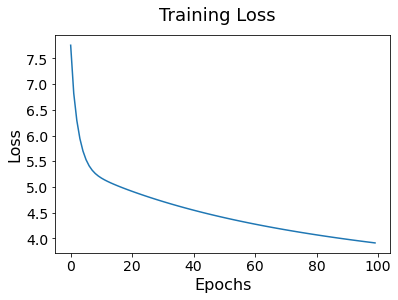

In [11]:
if __name__ == "__main__":
    lr =0.1
    epochs = 100
    lamb =0.001

    print("Training Accuracy \n")
    w, b, losses =  fit_reg_lamb(X_train, train_y, lr=lr, epochs=epochs, lamb=lamb)
    train_accuracy, confusion_matrix, sum_preds, sum_correct, misclassification_error = model_predict_accuracy(X_train, train_y, w, b)
    print('\n')
    print("Accuracy:",train_accuracy)
    #print('confusion_matrix:')
    #print(confusion_matrix, '\n')
    print("sum_preds               :", int(sum_preds)) 
    print("sum_correct_predictions :", int(sum_correct)) 
    print("sum_wrong_predictions   :", int(sum_preds - sum_correct))
    print("misclassification_error :", misclassification_error)
    
    fig = plt.figure()
    fig.suptitle('Training Loss', fontsize=18)
    plt.plot(losses)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    fig.savefig('Loss_plot_Training_without_Val.jpg')
    
    print('\n')
    print("Test Predictions")
    test_predictions = predict(X_test, w, b)
    df = pd.DataFrame(test_predictions)
    df.index.name= 'Index'
    file_name = f'test_predictions_lr{str(lr)}_lambda{str(lamb)}_epochs{str(epochs)}_Without_Val.csv'
    df.to_csv(file_name, index=True)



Training Accuracy 

Epoch 0 ==> Total CostJ = 17.574170684384733
Epoch 100 ==> Total CostJ = 13.232918013634391
Epoch 200 ==> Total CostJ = 12.327744043796876
Epoch 300 ==> Total CostJ = 11.690871982680605
Epoch 400 ==> Total CostJ = 11.168036335512467
Epoch 500 ==> Total CostJ = 10.710864431503603
Epoch 600 ==> Total CostJ = 10.298337416417697
Epoch 700 ==> Total CostJ = 9.919402997408168
Epoch 800 ==> Total CostJ = 9.567443319800034
Epoch 900 ==> Total CostJ = 9.238112752723659
Epoch 1000 ==> Total CostJ = 8.928356860858466
Epoch 1100 ==> Total CostJ = 8.635913153045559
Epoch 1200 ==> Total CostJ = 8.359033952406993
Epoch 1300 ==> Total CostJ = 8.096322112417578
Epoch 1400 ==> Total CostJ = 7.846628537697697
Epoch 1500 ==> Total CostJ = 7.608985577959798
Epoch 1600 ==> Total CostJ = 7.382562218069317
Epoch 1700 ==> Total CostJ = 7.166633015329872
Epoch 1800 ==> Total CostJ = 6.9605559874010705
Epoch 1900 ==> Total CostJ = 6.763756492861901
Epoch 2000 ==> Total CostJ = 6.5757152256054

NameError: name 'X_val' is not defined

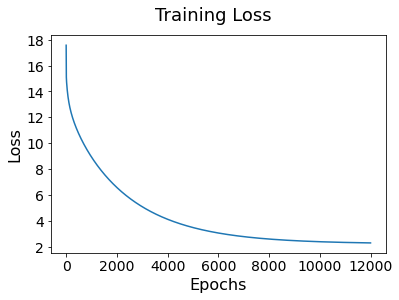

In [12]:
if __name__ == "__main__":
    lr =0.1
    epochs = 12000
    lamb = 100.0

    print("Training Accuracy \n")
    w, b, losses =  fit_reg_lamb(X_train, train_y, lr=lr, epochs=epochs, lamb=lamb)
    train_accuracy, confusion_matrix, sum_preds, sum_correct, misclassification_error = model_predict_accuracy(X_train, train_y, w, b)
    print('\n')
    print("Accuracy:",train_accuracy)
    #print('confusion_matrix:')
    #print(confusion_matrix, '\n')
    print("sum_preds               :", int(sum_preds)) 
    print("sum_correct_predictions :", int(sum_correct)) 
    print("sum_wrong_predictions   :", int(sum_preds - sum_correct))
    print("misclassification_error :", misclassification_error)
    
    fig = plt.figure()
    fig.suptitle('Training Loss', fontsize=18)
    plt.plot(losses)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    fig.savefig('Loss_plot_Training.jpg')

    
    print('\n')
    print("Validation Accuracy \n")
    val_accuracy, val_confusion_matrix, val_sum_preds, val_sum_correct, val_misclassification_error = model_predict_accuracy(X_val, val_y, w, b)
    print("Accuracy:",val_accuracy)
    #print('confusion_matrix:')
    #print(confusion_matrix, '\n')
    print("sum_preds               :", int(val_sum_preds)) 
    print("sum_correct_predictions :", int(val_sum_correct)) 
    print("sum_wrong_predictions   :", int(val_sum_preds - val_sum_correct))
    print("misclassification_error :", val_misclassification_error)
    
    
    print('\n')
    print("Test Predictions")
    test_predictions = predict(X_test, w, b)
    df = pd.DataFrame(test_predictions)
    df.index.name= 'Index'
    file_name = f'test_predictions_lr{str(lr)}_lambda{str(lamb)}_epochs{str(epochs)}_rerun1.csv'
    df.to_csv(file_name, index=True)

In [ ]:
if __name__ == "__main__":
    lr =0.1
    epochs = 12000
    lamb = 1000.0

    print("Training Accuracy \n")
    w, b, losses =  fit_reg_lamb(X_train, train_y, lr=lr, epochs=epochs, lamb=lamb)
    train_accuracy, confusion_matrix, sum_preds, sum_correct, misclassification_error = model_predict_accuracy(X_train, train_y, w, b)
    print('\n')
    print("Accuracy:",train_accuracy)
    #print('confusion_matrix:')
    #print(confusion_matrix, '\n')
    print("sum_preds               :", int(sum_preds)) 
    print("sum_correct_predictions :", int(sum_correct)) 
    print("sum_wrong_predictions   :", int(sum_preds - sum_correct))
    print("misclassification_error :", misclassification_error)
    
    fig = plt.figure()
    fig.suptitle('Training Loss', fontsize=18)
    plt.plot(losses)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    fig.savefig('Loss_plot_Training.jpg')

    
    print('\n')
    print("Validation Accuracy \n")
    val_accuracy, val_confusion_matrix, val_sum_preds, val_sum_correct, val_misclassification_error = model_predict_accuracy(X_val, val_y, w, b)
    print("Accuracy:",val_accuracy)
    #print('confusion_matrix:')
    #print(confusion_matrix, '\n')
    print("sum_preds               :", int(val_sum_preds)) 
    print("sum_correct_predictions :", int(val_sum_correct)) 
    print("sum_wrong_predictions   :", int(val_sum_preds - val_sum_correct))
    print("misclassification_error :", val_misclassification_error)
    
    
    print('\n')
    print("Test Predictions")
    test_predictions = predict(X_test, w, b)
    df = pd.DataFrame(test_predictions)
    df.index.name= 'Index'
    file_name = f'test_predictions_lr{str(lr)}_lambda{str(lamb)}_epochs{str(epochs)}_rerun1.csv'
    df.to_csv(file_name, index=True)